In [1]:
import os
from pathlib import Path
import numpy as np
from PIL import Image
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, filters, feature, morphology, measure, transform
import skimage.transform

import cv2

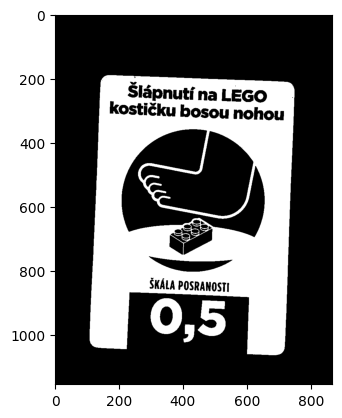

In [7]:
"""
Task: Detect card corners and fix perspective
"""


import cv2
import numpy as np


img_path_raw = "/home/silverjoda/SW/st_happens/st_happens/data/raw_imgs"
img_path = os.path.join(img_path_raw, "1.jpg") 

# Read image with cv2
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.bitwise_not(gray)
ret,thresh = cv2.threshold(gray,200,255,0)



plt.imshow(thresh, cmap="gray")

In [9]:
## Get contours
contours,h = cv2.findContours(thresh,cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

## only draw contour that have big areas
imx = img.shape[0]
imy = img.shape[1]
lp_area = (imx * imy) / 10

In [12]:

#################################################################
# Four point perspective transform
# https://www.pyimagesearch.com/2014/08/25/4-point-opencv-getperspective-transform-example/
#################################################################

def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype = "float32")
    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    # return the ordered coordinates
    return rect


def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    # return the warped image
    return warped


#################################################################


## Get only rectangles given exceeding area
for cnt in contours:
    approx = cv2.approxPolyDP(cnt,0.01 * cv2.arcLength(cnt, True), True)
    ## calculate number of vertices
    print(len(approx))

    if len(approx) == 4 and cv2.contourArea(cnt) > lp_area:
        print("rectangle")

        tmp_img = img.copy()
        cv2.drawContours(tmp_img, [cnt], 0, (0, 255, 255), 6)
        cv2.imshow('Contour Borders', tmp_img)
        cv2.waitKey(0)


        tmp_img = img.copy()
        cv2.drawContours(tmp_img, [cnt], 0, (255, 0, 255), -1)
        cv2.imshow('Contour Filled', tmp_img)
        cv2.waitKey(0)


        # Make a hull arround the contour and draw it on the original image
        tmp_img = img.copy()
        mask = np.zeros((img.shape[:2]), np.uint8)
        hull = cv2.convexHull(cnt)
        cv2.drawContours(mask, [hull], 0, (255, 255, 255), -1)
        cv2.imshow('Convex Hull Mask', mask)
        cv2.waitKey(0)


        # Draw minimum area rectangle
        tmp_img = img.copy()
        rect = cv2.minAreaRect(cnt)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        cv2.drawContours(tmp_img, [box], 0, (0, 0, 255), 2)
        cv2.imshow('Minimum Area Rectangle', tmp_img)
        cv2.waitKey(0)


        # Draw bounding rectangle
        tmp_img = img.copy()
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(tmp_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.imshow('Bounding Rectangle', tmp_img)
        cv2.waitKey(0)


        # Bounding Rectangle and Minimum Area Rectangle
        tmp_img = img.copy()
        rect = cv2.minAreaRect(cnt)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        cv2.drawContours(tmp_img, [box], 0, (0, 0, 255), 2)
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(tmp_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.imshow('Bounding Rectangle', tmp_img)
        cv2.waitKey(0)


        # determine the most extreme points along the contour
        # https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/
        tmp_img = img.copy()
        extLeft = tuple(cnt[cnt[:, :, 0].argmin()][0])
        extRight = tuple(cnt[cnt[:, :, 0].argmax()][0])
        extTop = tuple(cnt[cnt[:, :, 1].argmin()][0])
        extBot = tuple(cnt[cnt[:, :, 1].argmax()][0])
        cv2.drawContours(tmp_img, [cnt], -1, (0, 255, 255), 2)
        cv2.circle(tmp_img, extLeft, 8, (0, 0, 255), -1)
        cv2.circle(tmp_img, extRight, 8, (0, 255, 0), -1)
        cv2.circle(tmp_img, extTop, 8, (255, 0, 0), -1)
        cv2.circle(tmp_img, extBot, 8, (255, 255, 0), -1)

        print("Corner Points: ", extLeft, extRight, extTop, extBot)

        cv2.imshow('img contour drawn', tmp_img)
        cv2.waitKey(0)
        #cv2.destroyAllWindows()

        ## Perspective Transform
        tmp_img = img.copy()
        pts = np.array([extLeft, extRight, extTop, extBot])
        warped = four_point_transform(tmp_img, pts)
        cv2.imshow("Warped", warped)
        cv2.waitKey(0)


cv2.destroyAllWindows()

11
17
14
12
4
5
12
5
8
10
5
13
15
14
14
4
13
15
8
11
13
10
8
12
12
18
12
14
11
14
18
10
12
14
10
12
14
16
8
12
6
14
6
12
15
16
11
12
12
4
12
15
14
11
8
14
14
13
15
15
4
17
15
15
11
12
16
14
10
15
12
15
13
8
13
11
19
23
16
13
12
8
4
4
17
14
9
13
20
13
12
13
9
13
15
19
17
4
6
7
16
16
15
4
4
10
